# Limpeza e manipulação de dados
Esse notebook demonstra a limpeza e modelagem de dados para uso no Amazon Personalize. O dataset contém informações sobre interações de usuários com itens de e-commerce. A partir dele, serão modelados 2 datasets:
### - Item Interactions
Deve conter as seguintes colunas:

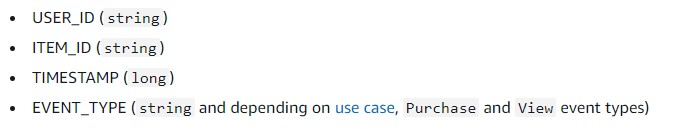

### - Items
Deve conter as seguintes colunas:

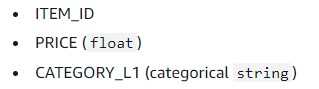

**Importando bibliotecas:**
O pandas será utilizado para lidar com o dataset. O numpy é utilizado apenas uma vez, para manter uma proporção no preenchimento de valores vazios.

In [ ]:
import pandas as pd
import numpy as np

**Importando o dataset:**
Aqui, o dataset é importado como um DataFrame, e a função head() mostra suas 5 primeiras linhas, para breve análise.

In [ ]:
df = pd.read_csv('events.csv')
df.head()

**Entendedo os dados:**
As seguintes linhas imprimem algumas informações gerais, como a quantidade de linhas e colunas, os DataTypes presentes e a quantidade de nulos.

In [ ]:
print('=============== Informações ============')
print(df.info())
print("========================================")
print('')
print('============= Linhas, colunas =========')
print(df.shape)
print("========================================")
print('')
print('=============== DataTypes ==============')
print(df.dtypes)
print("========================================")
print('')
print("================= Nulos ================")
print(df.isnull().sum())
print("========================================")

**Apagando nulos:**
Como os nulos são poucos e estão localizados em colunas importantes, é mais fácil apagar as linhas em que os valores estão faltando.

In [ ]:
df.dropna(inplace=True)
print(df.shape)
df.isnull().sum()

**Gereciando colunas:**
As colunas são renomeadas para atenderem aos requisitos do Amazon Personalize. Colunas inúteis são apagadas e as restantes serão gerenciadas mais tarde.

In [ ]:
df.rename(columns={'user_id': 'USER_ID', 'event_time': 'TIMESTAMP',
                   'product_id': 'ITEM_ID', 'event_type': 'EVENT_TYPE'}, inplace=True)

df.drop(columns=['user_session', 'category_id'], inplace=True)
df.head()

**Alterando Data Type:**
As colunas de ID foram importadas como int. Para compatibilidade com o serviço da Amazon, é necessário convertê-las para string.

In [ ]:
df['ITEM_ID'] = df['ITEM_ID'].astype(str)
df['USER_ID'] = df['USER_ID'].astype(str)

**Analisando coluna EVENT_TYPE:**
O seguinte comando exibe os diferentes valores presentes na coluna.

In [ ]:
df['EVENT_TYPE'].value_counts()

**Adaptando coluna EVENT_TYPE:**
São realizadas duas alterações para atendar aos requisitos de compatibilidade:


1.   Os eventos são capitalizados
2.   Apenas eventos "Purchase" E "View" são aceitos. Então, todos os eventos "Cart" são substituidos por um dos dois valores possíveis, na mesma proporção que eles apareciam anteriormente (no caso, algo entre 98% de view e 2% de purchase)



In [ ]:
df['EVENT_TYPE'] = df.apply(lambda row: row['EVENT_TYPE'].capitalize(), axis=1)

View_count = df['EVENT_TYPE'].value_counts().get('View', 0)
Purchase_count = view = df['EVENT_TYPE'].value_counts().get('Purchase', 0)

View_ratio = View_count / (View_count + Purchase_count)
Purchase_ratio = 1 - View_ratio

mask = df['EVENT_TYPE'] == 'Cart'
replace_values = np.random.choice(['Purchase', 'View'], mask.sum(),
                                  p=[Purchase_ratio, View_ratio])
df.loc[mask, 'EVENT_TYPE'] = replace_values

df['EVENT_TYPE'].value_counts()

**Alterando coluna de data:**
A coluna de Timestamp precisa estar em formato long (quantidade de segundos desde 01/01/1970). As seguintes linhas realizam essa alteração e imprimem a tabela para checar.

In [ ]:
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP']).dt.tz_localize(None)
df['TIMESTAMP'] = (df['TIMESTAMP'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
df['TIMESTAMP'].head()

**Criando dataset de items:**
O DataFrame que foi trabalhado até agora será o dataset de item interactions. Copiaremos algumas das colunas para um novo DataFrame, que será o de items.

In [ ]:
items_df = df[['category_code', 'brand', 'price', 'ITEM_ID']].copy()
items_df.rename(columns={'category_code': 'CATEGORY_L1', 'price': 'PRICE'}, inplace=True)
items_df.head()

**Excluindo duplicados:**
Como a tabela original é de items interactions, logicamente existem múltiplas linhas com o mesmo ITEM_ID. Como queremos apenas as informações sobre cada item, podemos excluir as duplicatas.

In [ ]:
print(items_df.duplicated(subset='ITEM_ID').sum())
items_df.drop_duplicates(subset='ITEM_ID', inplace=True)
print("============ DUPLICADOS REMOVIDOS =============")
print(items_df.duplicated(subset='ITEM_ID').sum())

**Criando coluna com o nome do item:**
A partir da categoria e da marca do item, que são os valores aos quais temos acesso, simularemos um nome para cada item, juntando a marca e a última palavra da categoria. Não será utilizado pelo Personalize, mas será utilizado para identificarmos o produto que está sendo recomendado.

In [ ]:
items_df['item_name'] = items_df.apply(lambda row: row['brand'] + ' ' + row['CATEGORY_L1'].split('.')[-1], axis=1)
items_df.drop('brand', axis=1, inplace=True)
items_df.head()

**Melhorando a coluna de categoria:**
No dataset, as categorias estão definidas como, por exemplo, "computer.network.router". Substituimos os pontos por espaços para torná-las melhor para leitura. Além disso, o DataType é alterado para "category", como pedido pelo Personalize.

In [ ]:
items_df['CATEGORY_L1'] = items_df.apply(lambda row: row['CATEGORY_L1'].replace('.', ' '), axis=1)
items_df['CATEGORY_L1'] = items_df['CATEGORY_L1'].astype('category')
items_df['CATEGORY_L1'].head()

**Limpando dataset de interactions:**
Agora, com o dataset de items pronto, podemos nos livrar das colunas desnecessárias.

In [ ]:
df.drop(columns=['category_code', 'brand', 'price'], inplace=True)
df.head()

In [ ]:
items_df.head()

**Salvando arquivos:**
Por fim, os dois DataFrames são salvos como csv para utilização com a ferramenta de Machine Learning da Amazon.

In [ ]:
df.to_csv('interactions.csv', index=False, float_format='%.0f')
items_df.to_csv('items.csv', index=False, float_format='%.0f')